# EECS 253 ML for Signal Processing
# Lecture 3: White Noise Methods

#Part 1: learning the filter

In the first part, we will assume we know an original datasource (which is just a random signal) and a linearly filtered version of that datasource.  The goal is to learn the weights of the linear filter.  This situation arises when someone else has filtered something and you want to figure out how.  It is also one way to "test" a system.   For instance, you may not know how a filter works, so you supply white noise input and see what comes out.  This is therefore a "white noise method" which is a large class that we will explore in the nonlinear domain.

The first filter to be learned will be an FIR (finite impulse response; all zero) filter, which as you recall is just a vector convolved with the original signal.  For instance if h(t) is a (short) vector that is the filter, and x(t) is the input, then the output is given by the convolution $y=h*x$, in other words:
\begin{equation}
 y(t) = \int x(t-\tau)h(\tau)d\tau  \\
 y(t) = \sum_{\tau = 0}^{N-1} x(t-\tau) h(\tau)
\end{equation}
where the first is continuous domain and the second is discrete domain (which is what you will use in digital computers).  $N$ is the length of the finite impulse response filter $<h(0)\ldots h(N-1)>$.

Note that convolution is commutative, so that $h*x=x*h$.
Also note that the filter is reverse direction from the data.  The filter goes backward in time while data goes forward.  In other words $x(t)$ gives the value going forward for each increasing value of $t$, whereas $h(0)$ is the filter value at time $t$, $h(1)$ is the filter value applied to the input at time $t-1$, etc.

We are going to learn $h$ from examples of $x(t)$ and $y(t)$.  We will do this by building a network that approximates $y(t) = f(x(t),x(t-1),\ldots, x(t-N))$.  The correct answer (in the discrete time domain), from above:
\begin{equation}
 y(t) = \sum_{\tau = 0}^{N-1} x(t-\tau) w(N-1-\tau)
\end{equation}
And from a network point of view, this means that the weights $w(0) \ldots w(N-1)$ ''slide'' over the input.  Technically that makes this a convolutional network, but that's not really important to our development (yet).  Note that the way that tensorflow networks work on timeseries data, weight $w0$ will apply to the earliest datapoint, so that the vector of weights runs forward in time, whereas the vector of the filter $h$ runs backward in time.

First we assume that we know that $y=h*x$ where $h$ has 5 elements, although we don't know what they are.  So our network $f$ just needs to be a linear network with 5 weights.  If it learns properly, after training the network weights should be exactly equal to the 5 filter coefficients.




# Initialization and loading data
These are the basic steps at the start of any project

In [ ]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#for all homework, please set the seeds of your random number generators to your UCI ID number
np.random.seed(57999719)
tf.random.set_seed(57999719)

#create the signals

We will choose an arbitrary filter 1,2,3,4,5.  Generate some white noise, run it through the "unknown" filter, and create the filtered output.  Then we will use the random signal and the filtered output to learn the "unkown" filter coefficients.

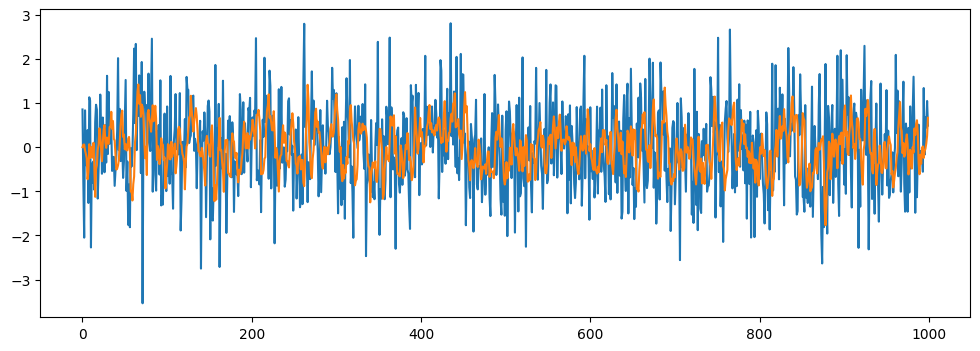

In [ ]:
#create a signal from filtered white noise
#here is the random number generator
from numpy.random import default_rng
rng = default_rng()
time_points = 1000
random_signal = rng.standard_normal(time_points)  #standard gaussian mean =0 std = 1
FIR_filter = [1,2,3,4,5]
FIR_filter = FIR_filter / np.sum(FIR_filter)
filtered_signal = np.convolve(random_signal, FIR_filter, 'full') #if use convolution mode:'same' will not line up
filtered_signal = np.append(0, filtered_signal[:len(random_signal)-1])  #will predict the NEXT output
plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(random_signal)
plt.plot(filtered_signal)


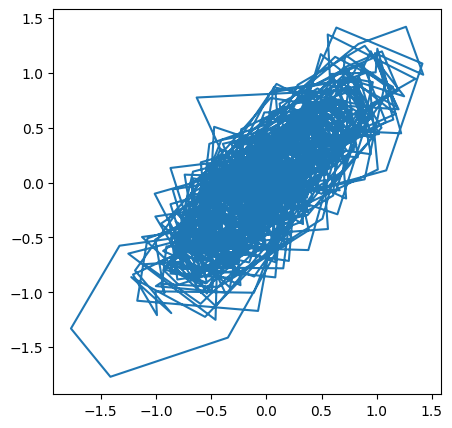

In [ ]:
# plot x(t) vs. x(t-1) to see a 2D "embedding" of a linear (and thus non-chaotic) system
# note that there is nothing that looks like limit-cycle behavior here
plt.figure(figsize=(5,5))
plt.plot(filtered_signal[:len(filtered_signal)-1],filtered_signal[1:]);

In [ ]:
#Make a series and dataframe with integer "timestamps"
randSeries = pd.Series(name='random', data=random_signal, index=range(0,len(random_signal)))
randDataFrame = randSeries.to_frame(name="random")
fsSeries = pd.Series(name='filtered', data=filtered_signal, index=range(0,len(filtered_signal)))
fsDataFrame = fsSeries.to_frame(name="filtered")
fsDataFrame

,filtered
0,0.000000
1,0.057005
2,0.059664
3,-0.074390
4,-0.152756
...,...
995,-0.088618
996,-0.039226
997,0.080220
998,0.258196


##Deterministic timeseries predictor

In [ ]:
#will use the last test_size elements in the series for test set validation and early stopping
#  in this case we need both the original random series and the filtered series
#  so we can predict one from the other
test_size = 100
test_ind = len(fsDataFrame)-test_size  #index of the first element to predict -1
fsTrain=fsDataFrame.iloc[:test_ind]  #train on everything before that
fsTest=fsDataFrame.iloc[test_ind:]   #test on everything after that
randTrain=randDataFrame.iloc[:test_ind]
randTest=randDataFrame.iloc[test_ind:]
#we will not do scaling this time, because we like the original scale (standard normal)

In [ ]:
#generator for the timeseries data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = len(FIR_filter)  #this is cheating; we know the length of the filter
#we are trying to "learn" the filter.  input is random sequence output is filtered sequence
#WARNING: you cannot pass a dataframe to timeseriesgenerator.  must be a numpy array
generator = TimeseriesGenerator(randTrain.to_numpy(), fsTrain.to_numpy(), length = predict_length, batch_size=1)
generator[0]




(array([[[ 0.85507121],
         [-0.81518491],
         [-2.05069981],
         [ 0.83533342],
         [-0.35509393]]]),
 array([[-0.25479401]]))

In [ ]:
#generator for the validation data
validation_generator = TimeseriesGenerator(randTest.to_numpy(),fsTest.to_numpy(), length=predict_length, batch_size=1)

In [ ]:
#create the network
#from tensorflow.tools.docs.doc_controls import do_not_doc_inheritable
#from matplotlib import use
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LSTM
n_features = 1
model = Sequential()
#if you don't flatten, will get a separate single-input net for each time value
#don't need to do this for LSTM layers; they flatten implicitly
model.add(Flatten(input_shape = (predict_length, n_features)))
model.add(Dense(1))  #this is a single output linear network
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
model.fit(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


895/895 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.6610 - val_loss: 1.1930
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9751 - val_loss: 0.3809
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3014 - val_loss: 0.0793
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0586 - val_loss: 0.0078
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0045 - val_loss: 2.0546e-04
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.9166e-05 - val_loss: 6.5536e-07
Epoch 7/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4857e-07 - val_loss: 1.1154e-10
Epoch 8/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0783e-11 - val_loss: 6.7269e-13
Epoch 9/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2332e-13 - val_loss: 2.7094e-13
Epoch 10/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4181e-13 - val_loss: 9.5716e-14


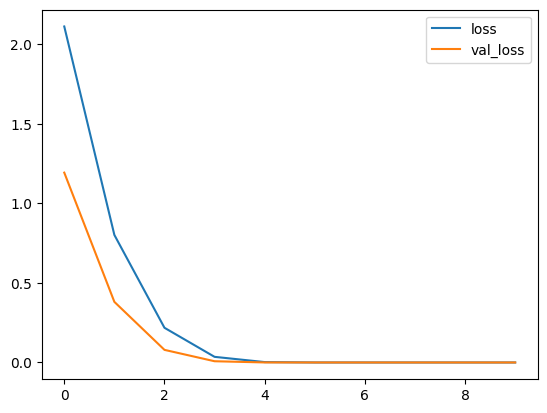

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot();

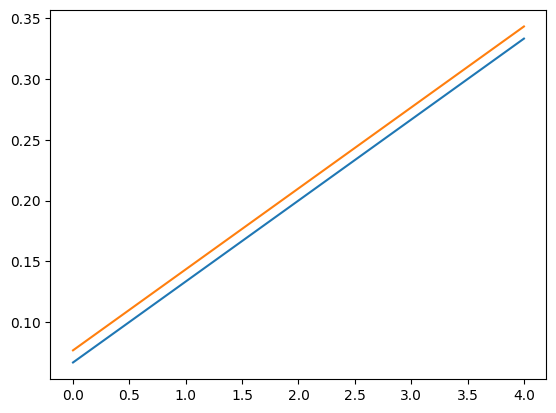

In [ ]:
plt.figure
model_weights = model.get_weights()[0]  #[0] converts this to a flat numpy array
plt.plot(model_weights[::-1])
#weights are in opposite order because of the way generator works
plt.plot(FIR_filter +0.01);  #add 0.01 so you can see both

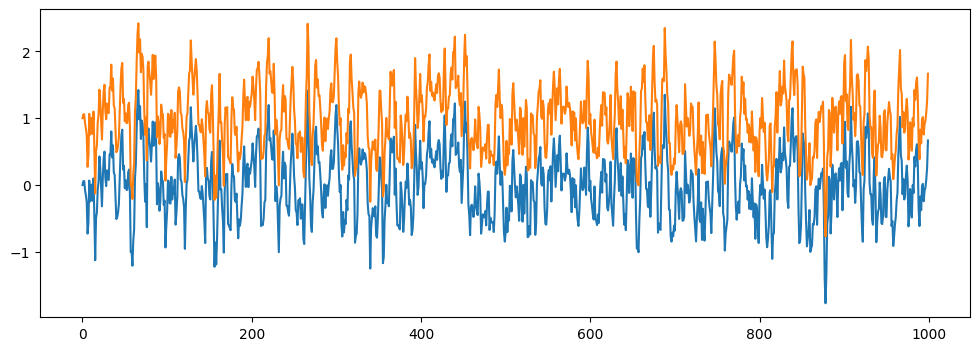

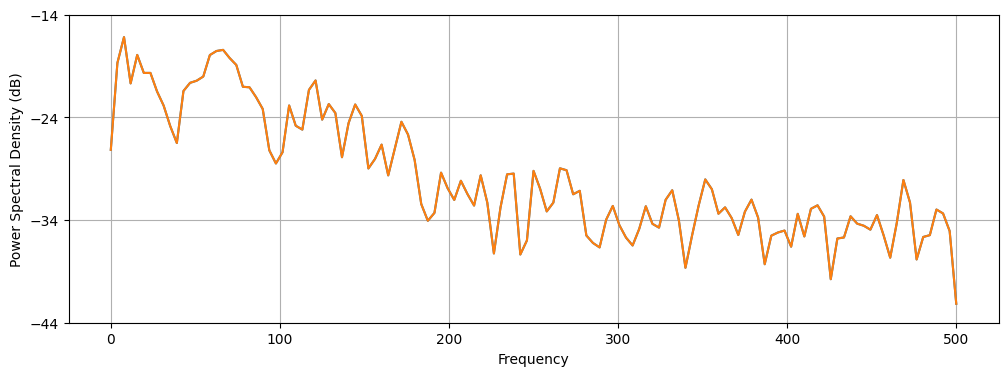

In [ ]:
#compare the predicted timeseries
predicted_FIR_filter= np.fliplr([model_weights.copy()])[0]  #model weights are reverse order and column vector
predicted_FIR_filter=predicted_FIR_filter.transpose()[0]  #make a row vector out of this. [0] converts matrix back to vector
predicted_filtered_signal = np.convolve(random_signal, predicted_FIR_filter, 'full') #now you can convolve
predicted_filtered_signal = np.append(0, predicted_filtered_signal[:len(random_signal)-1]) #adjust for prediction as before

plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(predicted_filtered_signal)
plt.plot(filtered_signal+1);  # to visualize because signals will be identical

plt.figure(figsize=(12,4))
plt.psd(predicted_filtered_signal, Fs=1000, scale_by_freq=0);
plt.psd(filtered_signal, Fs=1000, scale_by_freq=0);

##Nonlinear filter white noise method

Now we are going to do the same thing for a nonlinear filter.  The idea is to use white noise input and observe the output to "probe" the nonlinear filter.  We then make a network model of the filter and determine how close it can approximate the true nonlinear filter.

The network will be a standard layered network with linear layers alternating with a memoryless nonlinearity such as rectified linear units.  The model to be probed will be described by a Volterra kernel expansion.

#Volterra Kernels

Any discrete-time bounded differentiable nonlinear system can be described by a Volterra expansion, which is a natural extension of the standard linear system.  For example, if a regular linear system is described as
\begin{equation}
  y(t) = \int h(\tau)x(t-\tau)d\tau
\end{equation}
then we can add additional terms that look at second-order and higher interactions, as well as a constant term:
\begin{equation}
  y(t) = h_0
  + \int h_1(\tau)x(t-\tau)d\tau \\
   + \int h_2(\tau_1,\tau_2)x(t-\tau_1)x(t-\tau_2)d\tau_1d\tau_2\\
   + \int h_3(\tau_1,\tau_2,\tau_3)x(t-\tau_1)x(t-\tau_2)x(t-\tau_3)d\tau_1d\tau_2d\tau_3\\
...etc
\end{equation}
You can think of this as a Taylor series applied to a timeseries.

(We won't go into it here, but it is worth noting that the Volterra coefficients $h_1, h_2, \ldots$ are not orthogonal to each other, and therefore must be found by regression.  There is an alternative version called the Wiener kernel expansion that uses linear combinations of the Volterra kernels which are orthogonal and thus can be independently calculated when the input looks like Gaussian white noise.  This tends to be much more efficient, but harder to write down.)






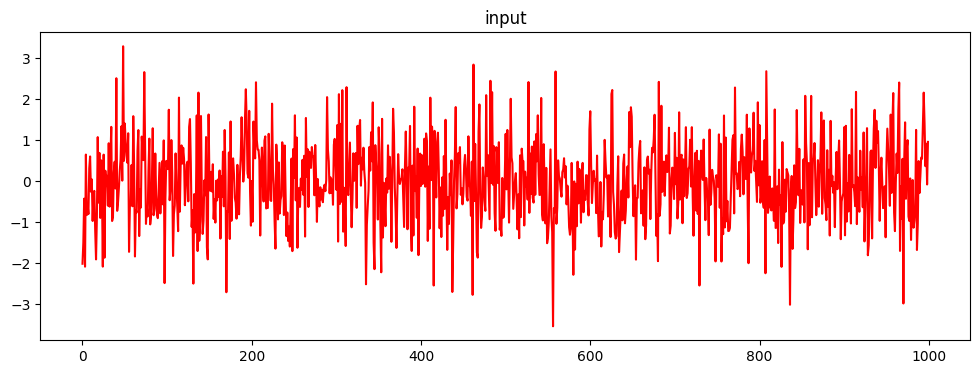

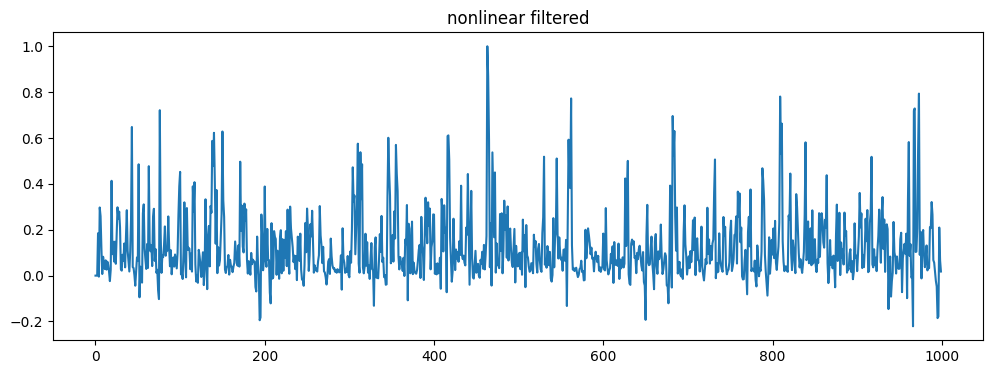

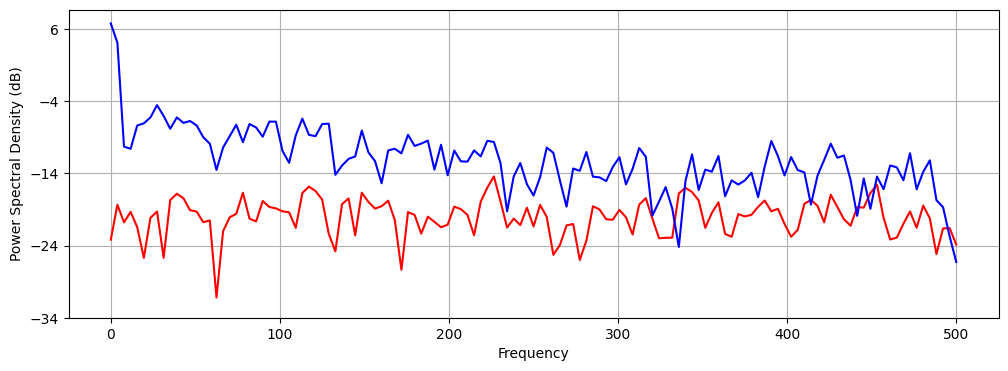

In [ ]:
#create a nonlinear signal from filtered white noise using a Volterra expansion

#here is the random number generator, same as before, to create the input
from numpy.random import default_rng
rng = default_rng()
time_points = 1000
random_signal = rng.standard_normal(time_points)  #standard gaussian mean =0 std = 1

#now create the volterra kernel
volterra_memory = 3  #number of past timepoints that contribute to the expansion
volterra_order = 2   #maximum polynomial order; more than 2 is usually unwieldy
                    #note that volterra_order=1 just gives a linear filter
#calculate the length of the kernel.  1(constant term) + memory(linear term) + memory^2 in this case
filter_length = 1
for n in range(1, volterra_order+1):
  filter_length = filter_length + volterra_memory**n
y = np.zeros(volterra_memory)  #set the first ones to zero so outputs line up
#now make some random coefficients (normally these might come from a polynomial fitting routine)
volterra_coefficients = rng.standard_normal(filter_length)

#now run the volterra kernel over the input to generate the output
for t in range(0,time_points-volterra_memory):
    x = random_signal[t:t+volterra_memory]  #last 3 time points
    xn = [1]  #constant term in volterra expansion
    inp = [1]
    for n in range(1,volterra_order+1):  #loop over the power (order) of volterra terms
      xn = np.outer(xn,x).ravel()    #this creates all the products x(t-i)x(t-j)...x(t-w) for the n'th order term
      inp = np.append(inp,xn)        #include all the terms, constant+linear+secondorder+...
                                     #each term has length volterra_memory**n including all possible cross-products
    y = np.append(y,np.dot(inp,volterra_coefficients))  #dot product multiplies by volterra coefficients to get output

#scale the range; tensorflow models learn more slowly if the output range is large
nonlinear_filtered_signal = y / np.max(np.abs(y))

plt.figure(figsize=(12,4))
plt.plot(random_signal,'r')
plt.title('input')
plt.figure(figsize=(12,4))
plt.plot(nonlinear_filtered_signal);
plt.title('nonlinear filtered');

plt.figure(figsize=(12,4))
plt.psd(random_signal, color='r', Fs=1000, scale_by_freq=0);
plt.psd(y, Fs=1000, color = 'b', scale_by_freq=0);



In [ ]:
#Make a series and dataframe with integer "timestamps"
randSeries = pd.Series(name='random', data=random_signal, index=range(0,len(random_signal)))
randDataFrame = randSeries.to_frame(name="random")
fsSeries = pd.Series(name='filtered', data=nonlinear_filtered_signal, index=range(0,len(nonlinear_filtered_signal)))
fsDataFrame = fsSeries.to_frame(name="filtered")

#will use the last test_size elements in the series for test set validation and early stopping
#  in this case we need both the original random series and the filtered series
#  so we can predict one from the other
test_size = 100
test_ind = len(fsDataFrame)-test_size  #index of the first element to predict -1
fsTrain=fsDataFrame.iloc[:test_ind]  #train on everything before that
fsTest=fsDataFrame.iloc[test_ind:]   #test on everything after that
randTrain=randDataFrame.iloc[:test_ind]
randTest=randDataFrame.iloc[test_ind:]
#we will not do scaling this time, because we like the original scale (standard normal)

In [ ]:
#generator for the timeseries data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = volterra_memory  #this is cheating; we know the length of the filter
#we are trying to "learn" the filter.  input is random sequence output is filtered sequence
#WARNING: you cannot pass a dataframe to timeseriesgenerator.  must be a numpy array
generator = TimeseriesGenerator(randTrain.to_numpy(), fsTrain.to_numpy(), length = predict_length, batch_size=1)

#generator for the validation data
validation_generator = TimeseriesGenerator(randTest.to_numpy(),fsTest.to_numpy(), length=predict_length, batch_size=1)

In [ ]:
#create the network
n_features = 1

#will use two nonlinear layers so that we can capture second-order interactions between inputs in the first layer
model = Sequential()
model.add(Flatten(input_shape = (predict_length, n_features)))
model.add(Dense(20, activation='sigmoid'))  #we know this will be a smooth (polynomial) function, so use smooth activation
model.add(Dense(20, activation = 'sigmoid'))
model.add(Dense(1))  #this is a single output linear network at the top to allow scaling to the correct output range
model.compile(optimizer='adam', loss='mse')  #mse because is a regression problem
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561 (2.19 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#longer early stopping because the first few iterations often dont seem to decrease the error
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=5)

Epoch 1/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1491 - val_loss: 0.0010
Epoch 2/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0024 - val_loss: 8.7436e-04
Epoch 3/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0018 - val_loss: 7.1199e-04
Epoch 4/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021 - val_loss: 8.0304e-04
Epoch 5/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0023 - val_loss: 5.2628e-04
Epoch 6/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0016 - val_loss: 6.0755e-04
Epoch 7/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012 - val_loss: 4.7458e-04
Epoch 8/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0014 - val_loss: 3.1794e-04
Epoch 9/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.3752e-04 - val_loss: 3.5496e-04
Epoch 10/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 2.9333e-04
Epoch 11/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.4733e-04 - val_loss: 6.3581e-04
Epoc

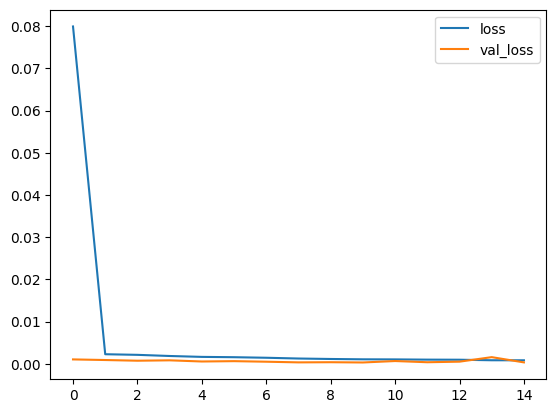

In [ ]:
#it can often take a while before the error starts to decrease.  if it gets stuck, try again
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot();

97/97 [==============================] - 0s 2ms/step


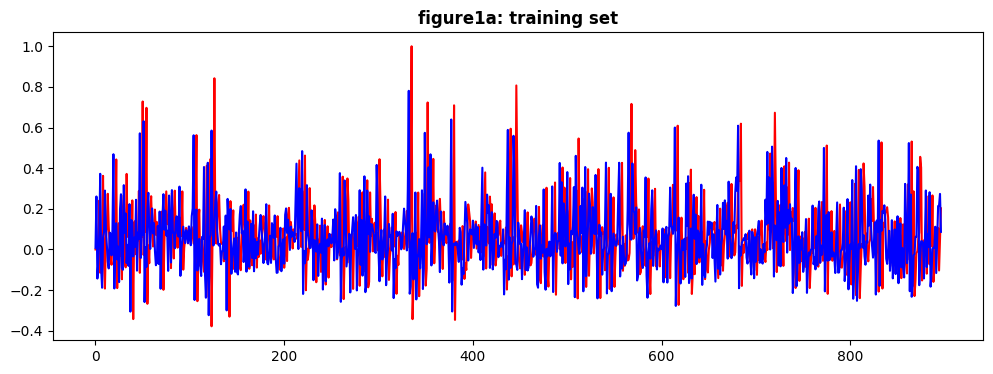

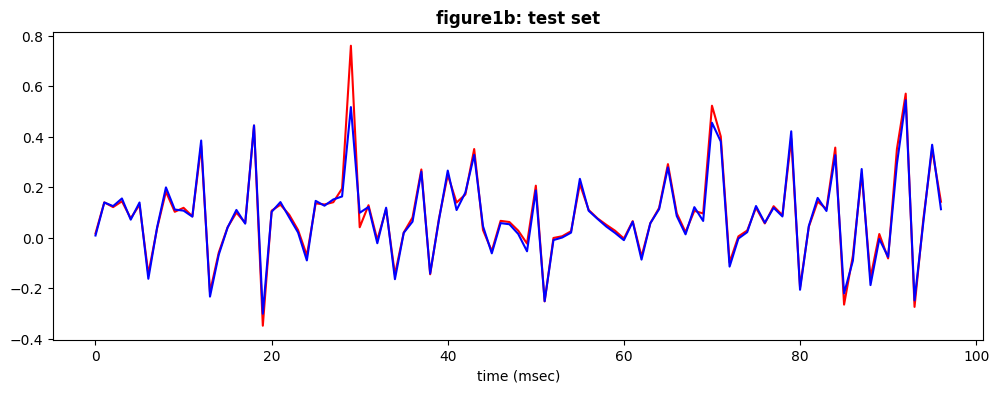

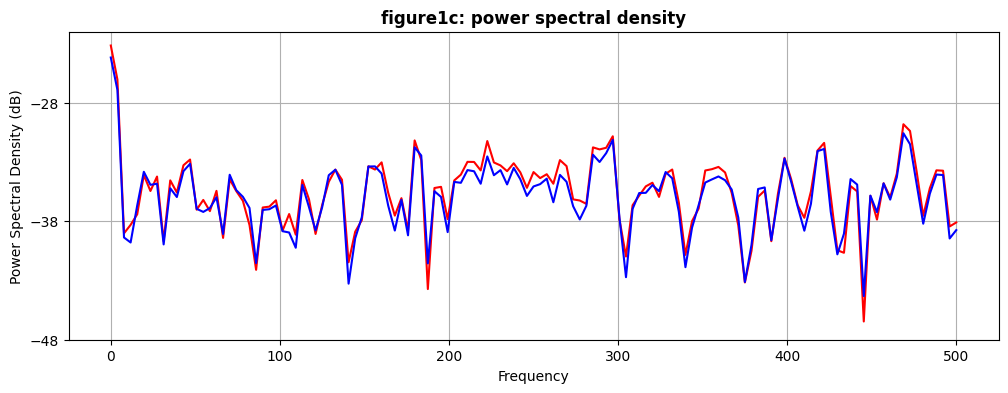

In [ ]:
#compare the predicted timeseries
predicted_outputs = model.predict(generator)
predicted_validation = model.predict(validation_generator)

plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(nonlinear_filtered_signal[:len(predicted_outputs)],'r')
plt.plot(predicted_outputs,'b')
plt.title('figure1a: training set',fontweight="bold")
plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(nonlinear_filtered_signal[-len(predicted_validation):],'r')
plt.plot(predicted_validation,'b')
plt.title('figure1b: test set',fontweight="bold");
plt.xlabel('time (msec)')

plt.figure(figsize=(12,4))
plt.psd(nonlinear_filtered_signal, color='r', Fs=1000, scale_by_freq=0);
plt.psd(predicted_outputs.ravel(), Fs=1000, color = 'b', scale_by_freq=0);  #use ravel to make a horizontal array
plt.title('figure1c: power spectral density',fontweight="bold");



##Homework 2

Run the nonlinear filter for different values of volterra_order (2,3,4).  Compare performance if you double the number of hidden units in one or both of the sigmoid layers of the network.  You may need to increase the training time (number of batches) to achieve convergence if you increase the network size.  You should run each case more than once because there is variability.  Keep track of the best performance (least loss and val_loss) for each case, and make a table.

Questions to think about:

1. What changes to the network are most helpful for decreasing error as you increase the order of the Volterra kernel?

2. Why do you think this is the case?

3. Can you guess a different activation function (other than sigmoid) that might work better?  Why?  What might go wrong?

For the homework, please turn in the table of loss and val_loss for each of the three networks (volterra_order = 2,3,4).  Also please turn in a pdf of figure1abc for each of the three networks.  If you test different numbers of hidden units, show only the best results for each volterra order.







**Answers to Questions:**
1. Increasing the number of units per layer helped bring the error down in general. This was especially true for orders 2 and 3.  
2.	Increasing the number of units per layer increasing the complexity and thereby the computational abilities of the network. This is why the error decreased as the model is able to learn more complex patterns.
3.	We use sigmoid activation instead of ReLu because we know that we are modelling a Volterra Series which is a differentiable, smooth function. Thus, we will use sigmoid which is also a smooth differentiable function so that we stay in the same class of functions (we are approximating a differentiable, smooth function with a differentiable, smooth function) which will have better accuracy than using ReLu. The other activation function we could have used would be the Tanh function (hyperbolic tangent function) which is a shifted version of the sigmoid. Thus, either sigma or tanh would be good functions to use as they are smooth and differentiable. We don't want to use ReLu because it is not differentiable at all values.

Another parameter to analyze in the future would be the patience parameter. Would increasing the patience parameter past 5 be useful for the situations where the model bounded around, or would the model continue to bounce around and never decrease even if the patience parameter were increased?
In general, as the order of Volterra Series increased the model began to suffer from oscillating val error which lead to the early stopping criteria being activated during the first 20 epochs. Thus, the network suffered from overfitting more often as the order increased.

# **Best Memory and Neuron Size Parameters for Order 2**

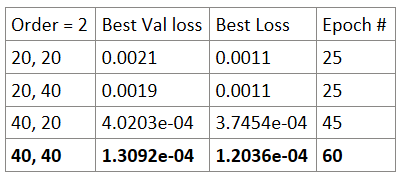

***Order 2: 20, 20***
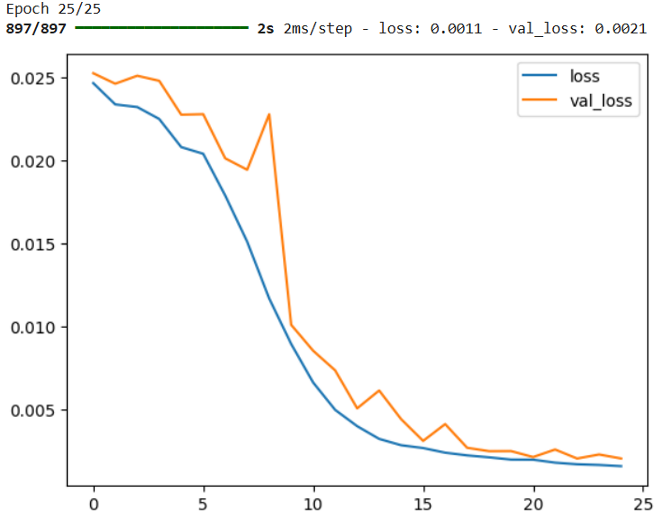

After running several iterations, I found that 25 epochs was best, as past 25 epochs the model did not improve

***Order 2: 20, 40***
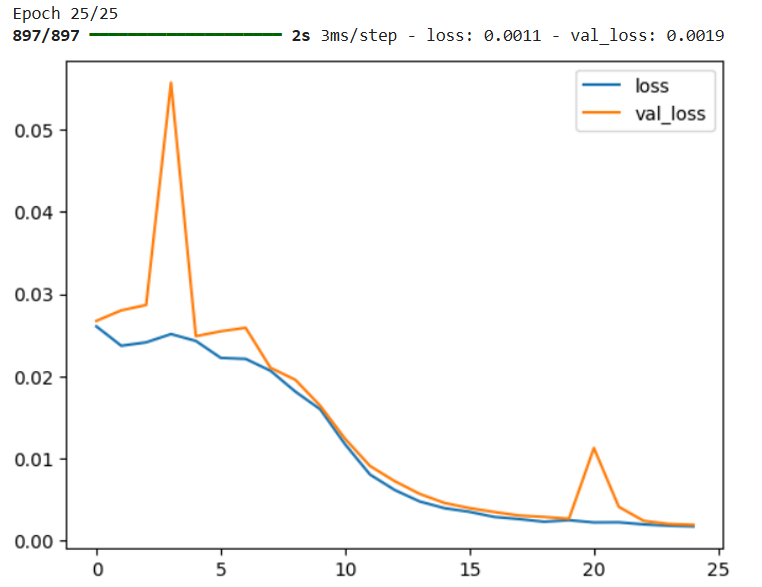
After running several iterations, I found that 25 epochs was best, as past 25 epochs the model did not improve.

***Order 2: 40, 20***
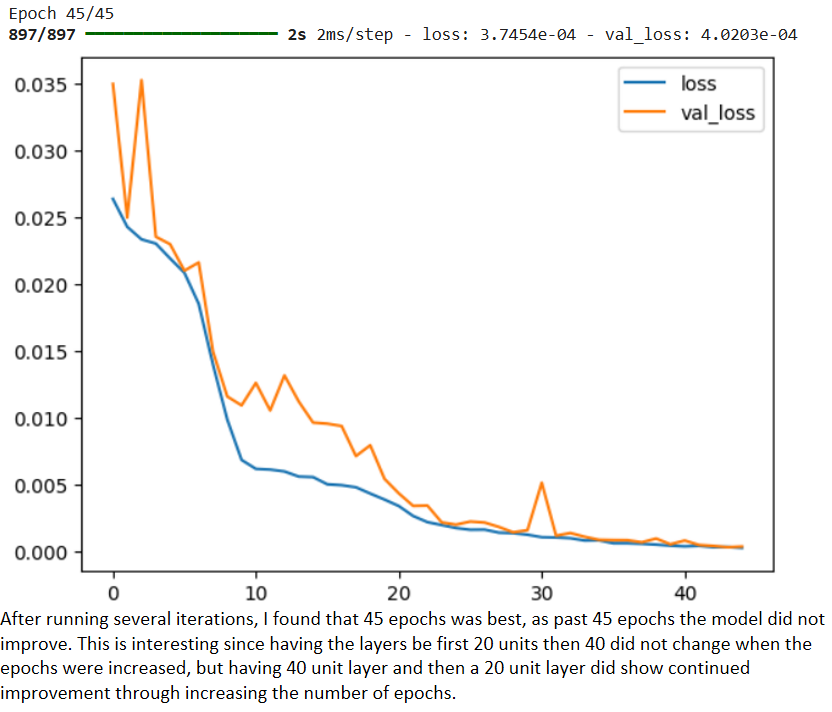

***Order 2: 40, 40***
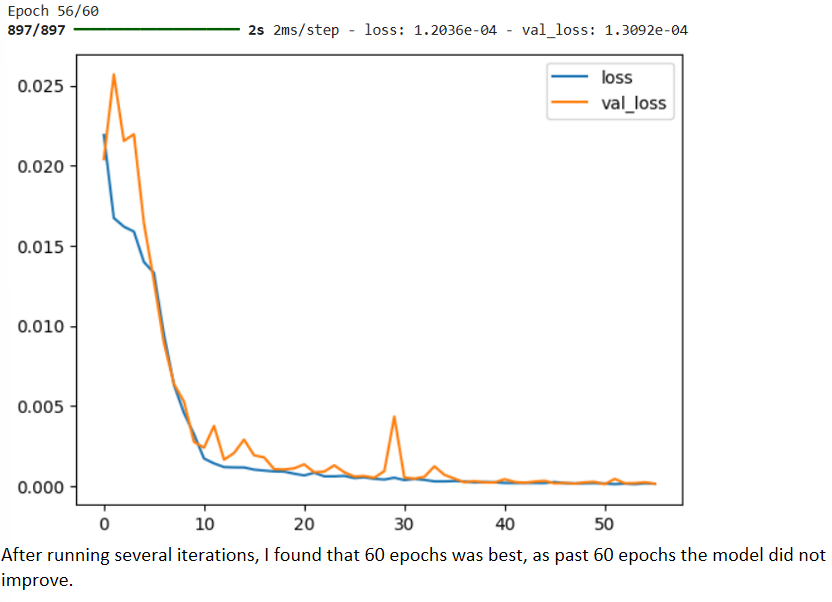

The figure 1abc for order 2: 40,40 is shown below
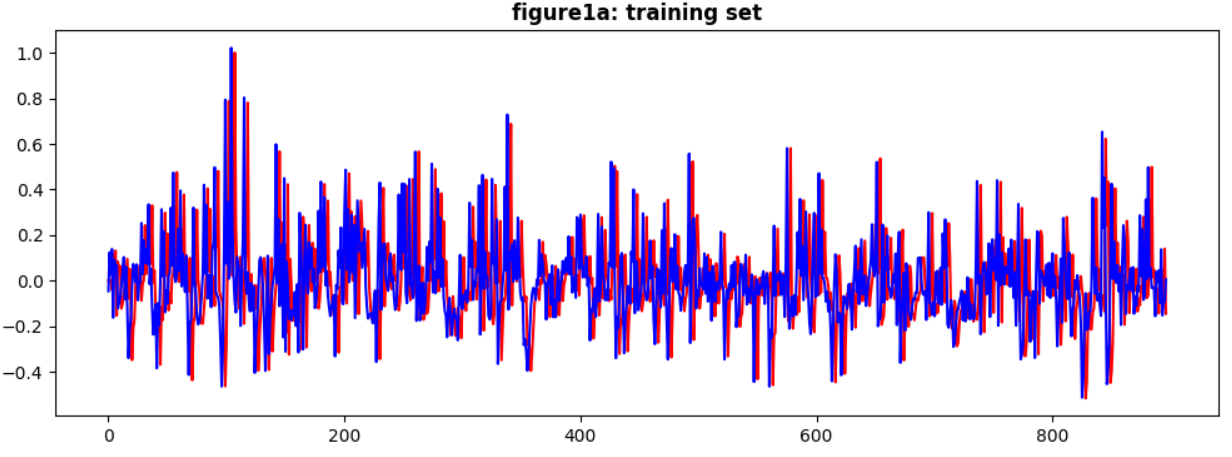

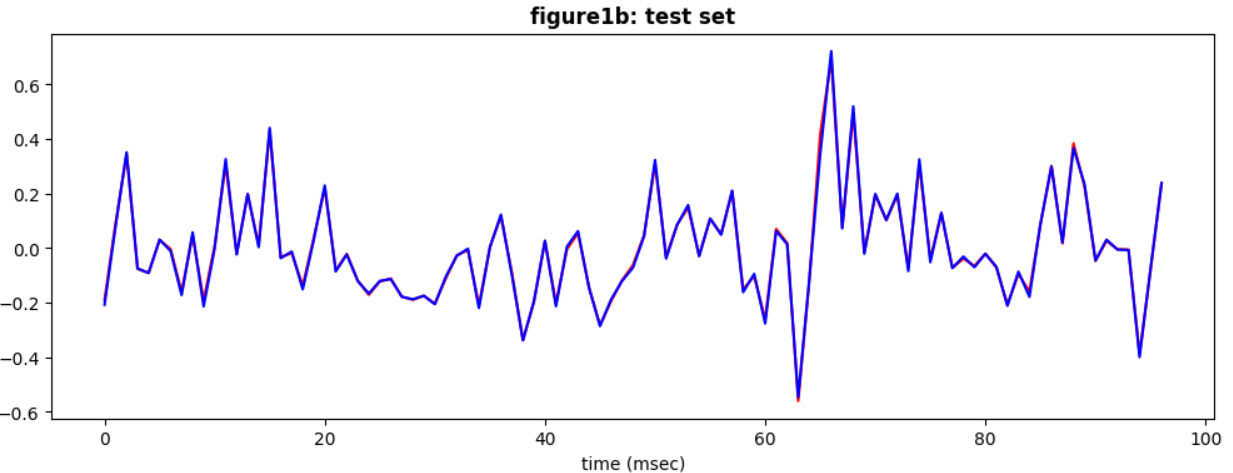

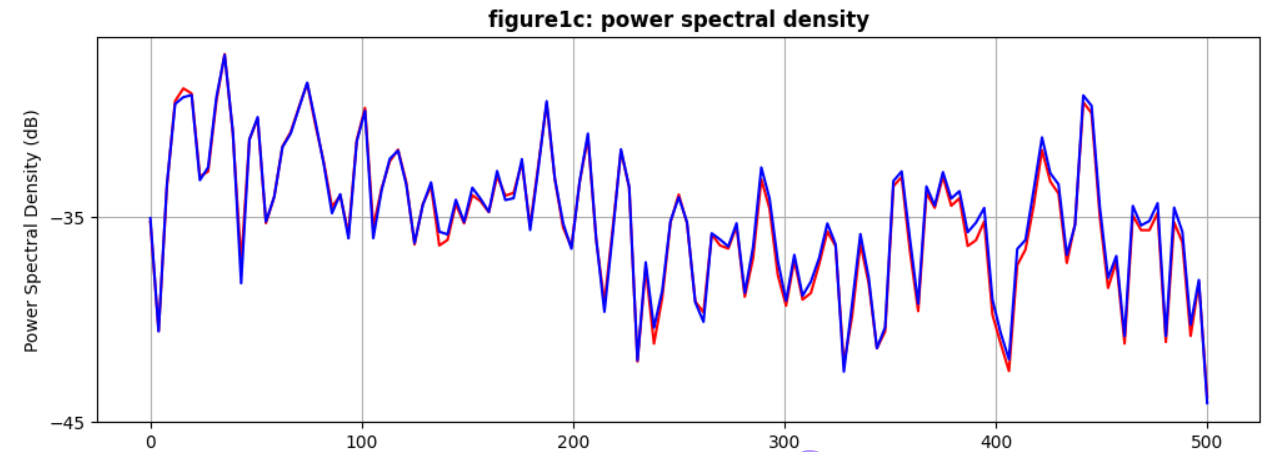

# **Best Memory and Neuron Size Parameters for Order 3**

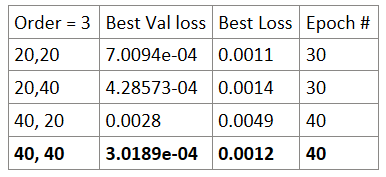

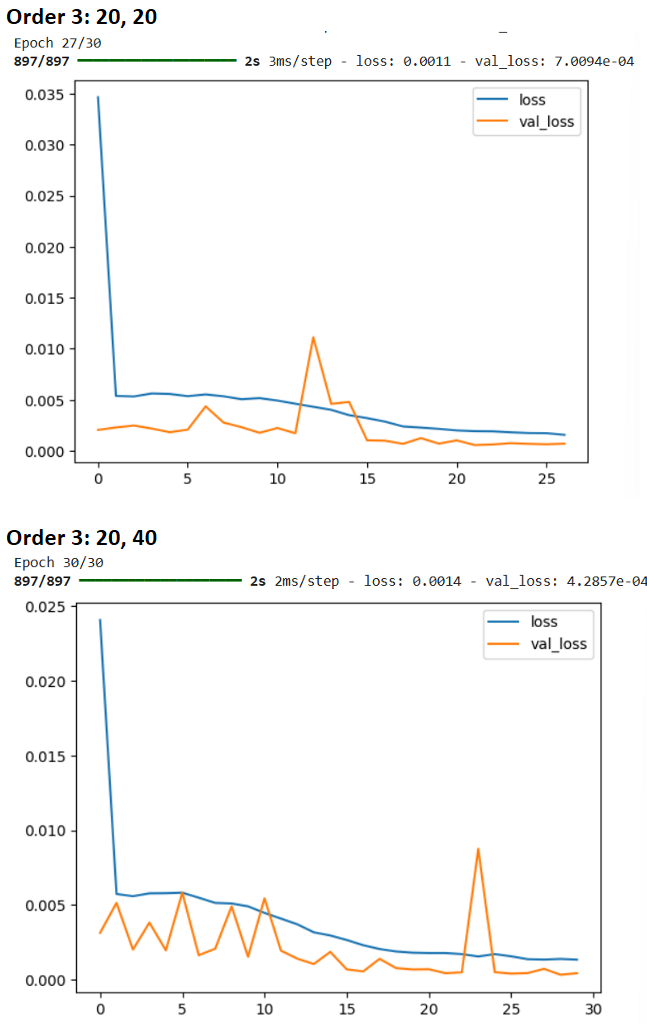

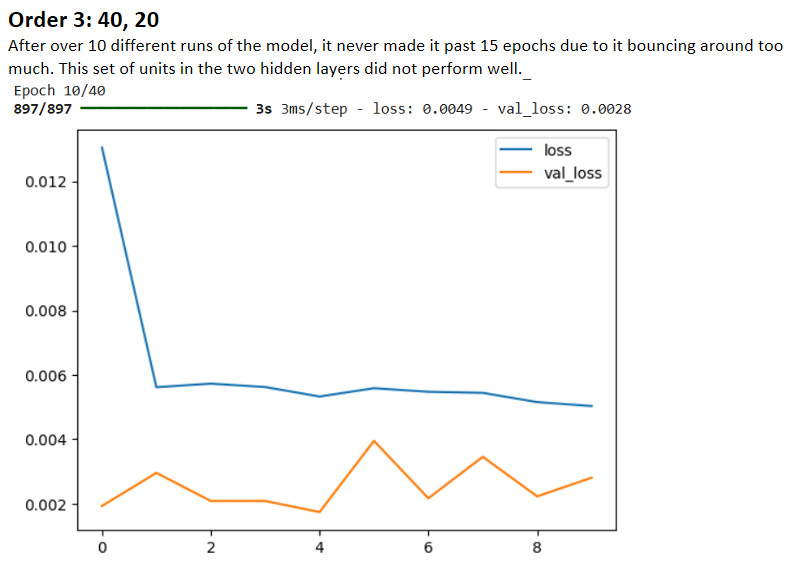

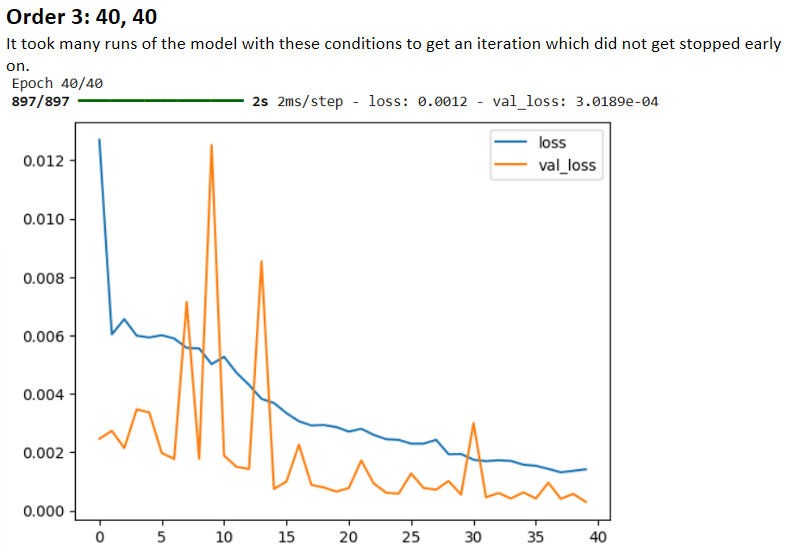

Here are the figures 1abc for Order 3: 40, 40

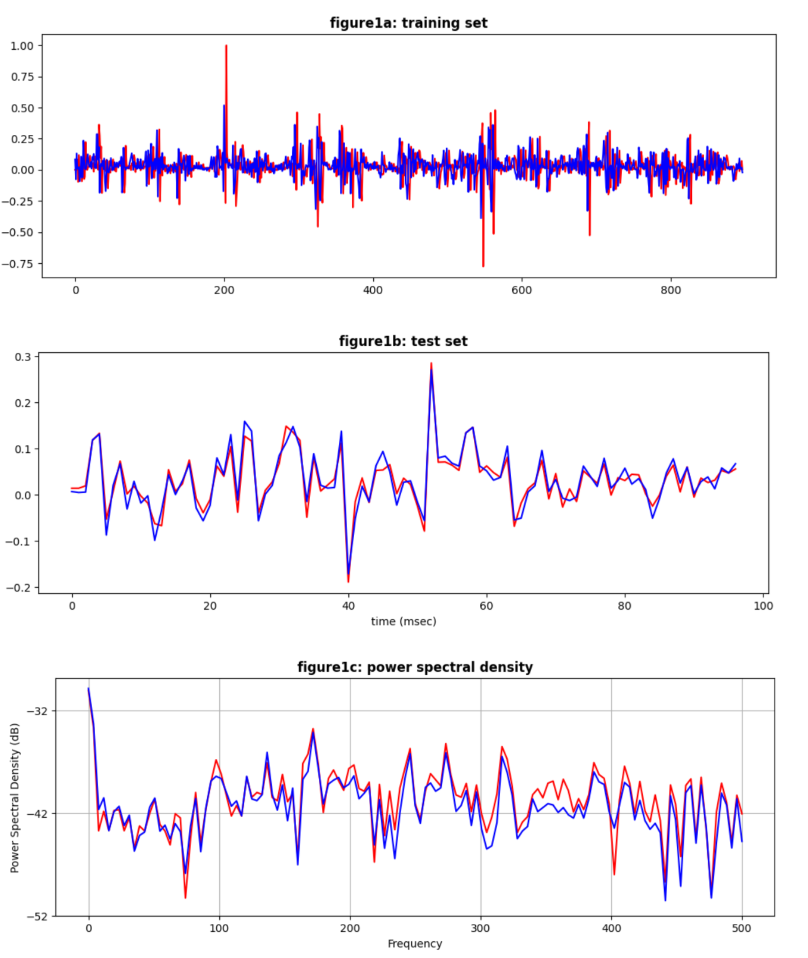

# **Best Memory and Neuron Size Parameters for Order 4**


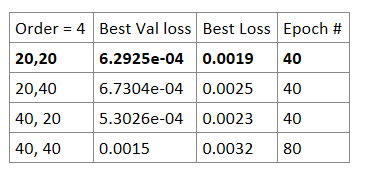

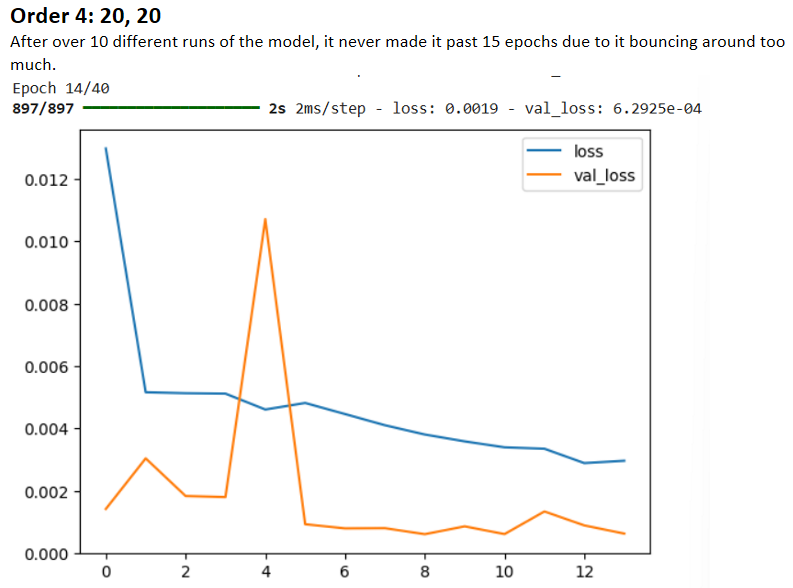

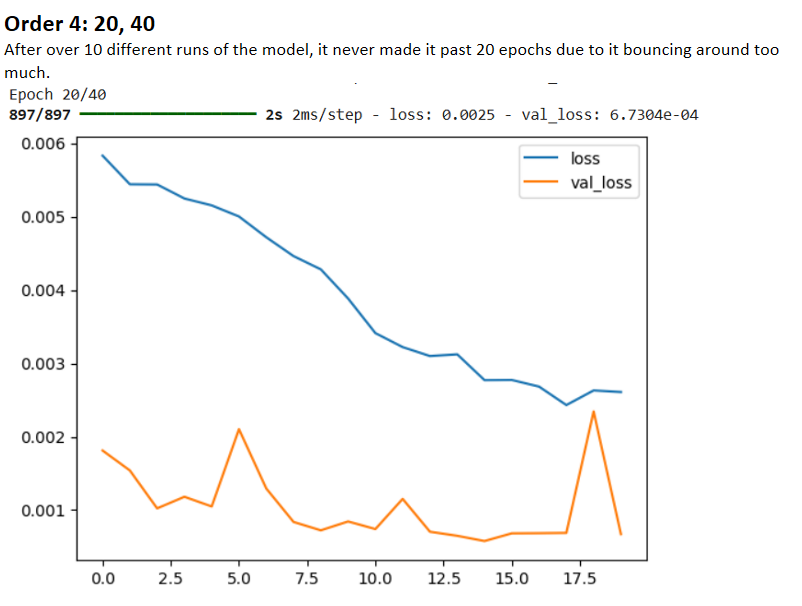

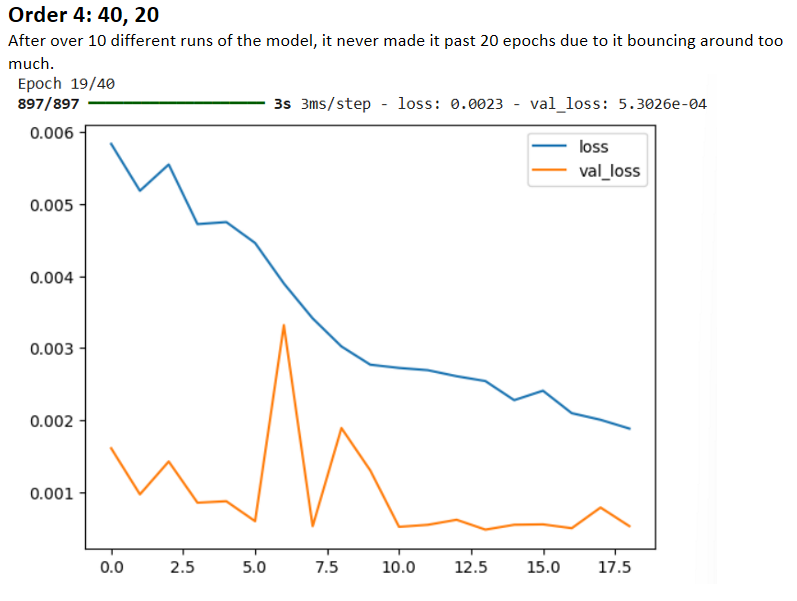

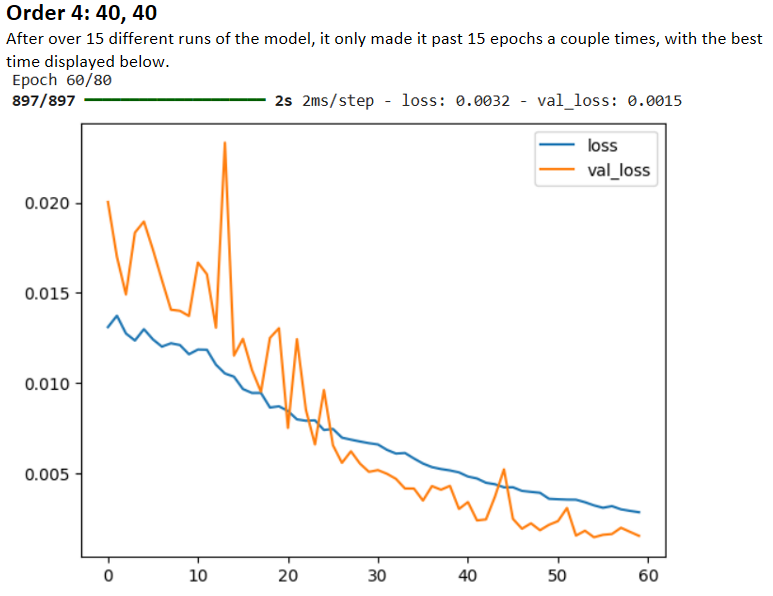

The best combination for Order 4 was 20, 20. Below are the figure 1abc plots for it:

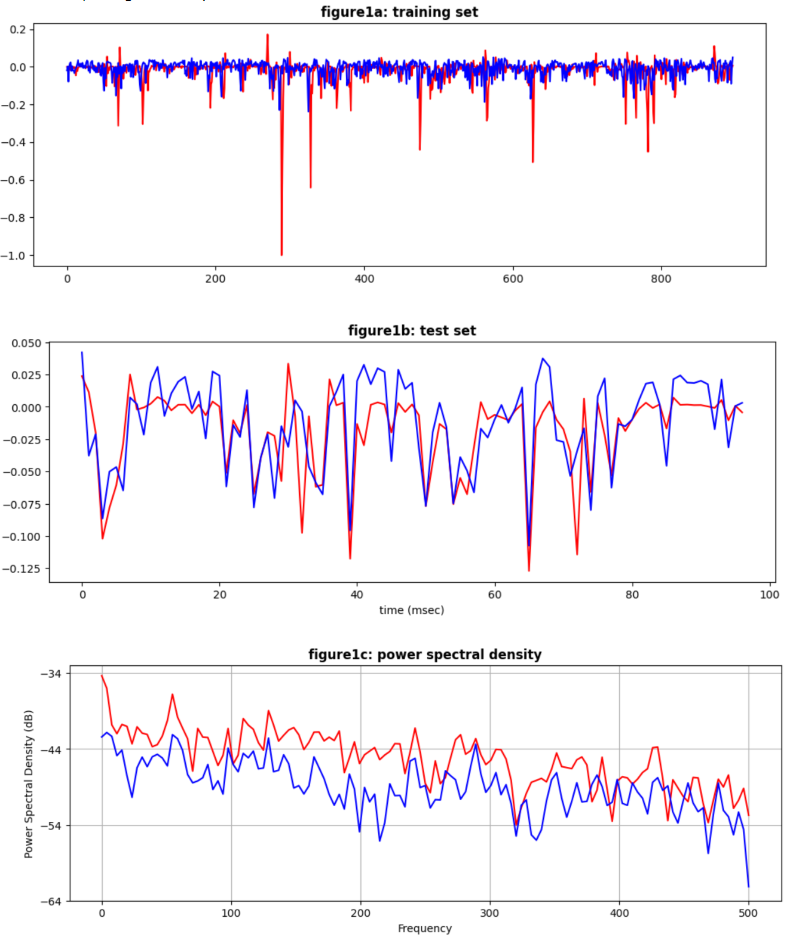